# 🎓 Graph Neural Networks for Citation Network Analysis
## Complete Self-Contained Implementation

**Tasks:**
- �� Node-Level Prediction: Paper topic classification
- 🔗 Edge-Level Prediction: Citation prediction

**Models:** GAT, GCN, GraphSAGE  
**Dataset:** OGB arXiv (169K papers, 40 topics)

In [ ]:
# Install required packages (run once)
!pip install torch torchvision
!pip install torch-geometric
!pip install ogb
!pip install matplotlib pandas numpy scikit-learn

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv, GCNConv, SAGEConv
from torch_geometric.data import Data
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, average_precision_score
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Random seeds
torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu


## 🏗️ Model Implementations

In [2]:
class GAT(nn.Module):
    """Graph Attention Network"""
    def __init__(self, in_channels, hidden_channels, out_channels, heads=4, dropout=0.3):
        super().__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=dropout)
        self.conv2 = GATConv(hidden_channels * heads, out_channels, heads=1, concat=False, dropout=dropout)
        self.dropout = dropout
        
    def forward(self, x, edge_index):
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x

class GCN(nn.Module):
    """Graph Convolutional Network"""
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.3):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.dropout = dropout
        
    def forward(self, x, edge_index):
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x

class GraphSAGE(nn.Module):
    """GraphSAGE Network"""
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.3):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)
        self.dropout = dropout
        
    def forward(self, x, edge_index):
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x

print("✅ Models defined: GAT, GCN, GraphSAGE")

✅ Models defined: GAT, GCN, GraphSAGE


## 📚 Load Dataset

In [9]:
# Fix for PyTorch 2.6+ compatibility with OGB
import torch.serialization
from torch_geometric.data.data import DataEdgeAttr, DataTensorAttr
from torch_geometric.data import Data
from torch_geometric.data.storage import GlobalStorage, EdgeStorage, NodeStorage

# Add all necessary torch_geometric classes to safe globals
torch.serialization.add_safe_globals([
    DataEdgeAttr, 
    DataTensorAttr, 
    Data, 
    GlobalStorage,
    EdgeStorage,
    NodeStorage
])

In [11]:
from ogb.nodeproppred import PygNodePropPredDataset

# Load OGB arXiv dataset
print("Loading OGB arXiv dataset...")
dataset = PygNodePropPredDataset(name='ogbn-arxiv', root='data/')
data = dataset[0]

# Add train/val/test masks
split_idx = dataset.get_idx_split()
data.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.val_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)

data.train_mask[split_idx['train']] = True
data.val_mask[split_idx['valid']] = True
data.test_mask[split_idx['test']] = True
data.y = data.y.view(-1)

print(f"\n📊 Dataset Statistics:")
print(f"Nodes (Papers): {data.num_nodes:,}")
print(f"Edges (Citations): {data.num_edges:,}")
print(f"Features: {data.num_features}")
print(f"Classes (Topics): {dataset.num_classes}")
print(f"Train: {data.train_mask.sum():,} | Val: {data.val_mask.sum():,} | Test: {data.test_mask.sum():,}")

Loading OGB arXiv dataset...

📊 Dataset Statistics:
Nodes (Papers): 169,343
Edges (Citations): 1,166,243
Features: 128
Classes (Topics): 40
Train: 90,941 | Val: 29,799 | Test: 48,603


## 🎯 Task 1: Node Classification (Topic Prediction)

In [12]:
def train_node_classification(model, data, epochs=100, lr=0.01):
    model = model.to(device)
    data = data.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    history = {'train_loss': [], 'val_acc': []}
    best_val_acc = 0
    
    for epoch in range(epochs):
        # Training
        model.train()
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()
        
        # Evaluation
        model.eval()
        with torch.no_grad():
            out = model(data.x, data.edge_index)
            pred = out.argmax(dim=1)
            val_acc = (pred[data.val_mask] == data.y[data.val_mask]).float().mean()
            
            history['train_loss'].append(loss.item())
            history['val_acc'].append(val_acc.item())
            
            if val_acc > best_val_acc:
                best_val_acc = val_acc.item()
        
        if (epoch + 1) % 20 == 0:
            print(f"Epoch {epoch+1}/{epochs}: Loss={loss.item():.4f}, Val Acc={val_acc:.4f}")
    
    # Test
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)
        test_acc = (pred[data.test_mask] == data.y[data.test_mask]).float().mean()
    
    print(f"Final: Val Acc={best_val_acc:.4f}, Test Acc={test_acc:.4f}\n")
    return history, test_acc.item()

In [13]:
# Train GAT
print("Training GAT for Node Classification...")
gat = GAT(data.num_features, 128, dataset.num_classes)
gat_history, gat_test_acc = train_node_classification(gat, data, epochs=100)

Training GAT for Node Classification...
Epoch 20/100: Loss=2.2047, Val Acc=0.4956
Epoch 20/100: Loss=2.2047, Val Acc=0.4956
Epoch 40/100: Loss=1.9372, Val Acc=0.5652
Epoch 40/100: Loss=1.9372, Val Acc=0.5652
Epoch 60/100: Loss=1.8629, Val Acc=0.5797
Epoch 60/100: Loss=1.8629, Val Acc=0.5797
Epoch 80/100: Loss=1.8326, Val Acc=0.5853
Epoch 80/100: Loss=1.8326, Val Acc=0.5853
Epoch 100/100: Loss=1.8237, Val Acc=0.5896
Epoch 100/100: Loss=1.8237, Val Acc=0.5896
Final: Val Acc=0.5896, Test Acc=0.5339

Final: Val Acc=0.5896, Test Acc=0.5339



In [14]:
# Train GCN
print("Training GCN for Node Classification...")
gcn = GCN(data.num_features, 128, dataset.num_classes)
gcn_history, gcn_test_acc = train_node_classification(gcn, data, epochs=100)

Training GCN for Node Classification...
Epoch 20/100: Loss=2.2580, Val Acc=0.4788
Epoch 20/100: Loss=2.2580, Val Acc=0.4788
Epoch 40/100: Loss=1.8564, Val Acc=0.5346
Epoch 40/100: Loss=1.8564, Val Acc=0.5346
Epoch 60/100: Loss=1.7303, Val Acc=0.5511
Epoch 60/100: Loss=1.7303, Val Acc=0.5511
Epoch 80/100: Loss=1.6764, Val Acc=0.5621
Epoch 80/100: Loss=1.6764, Val Acc=0.5621
Epoch 100/100: Loss=1.6459, Val Acc=0.5707
Final: Val Acc=0.5722, Test Acc=0.5033

Epoch 100/100: Loss=1.6459, Val Acc=0.5707
Final: Val Acc=0.5722, Test Acc=0.5033



In [15]:
# Train GraphSAGE
print("Training GraphSAGE for Node Classification...")
sage = GraphSAGE(data.num_features, 128, dataset.num_classes)
sage_history, sage_test_acc = train_node_classification(sage, data, epochs=100)

Training GraphSAGE for Node Classification...
Epoch 20/100: Loss=2.0967, Val Acc=0.4612
Epoch 20/100: Loss=2.0967, Val Acc=0.4612
Epoch 40/100: Loss=1.7392, Val Acc=0.5415
Epoch 40/100: Loss=1.7392, Val Acc=0.5415
Epoch 60/100: Loss=1.6288, Val Acc=0.5687
Epoch 60/100: Loss=1.6288, Val Acc=0.5687
Epoch 80/100: Loss=1.5724, Val Acc=0.5791
Epoch 80/100: Loss=1.5724, Val Acc=0.5791
Epoch 100/100: Loss=1.5453, Val Acc=0.5853
Epoch 100/100: Loss=1.5453, Val Acc=0.5853
Final: Val Acc=0.5853, Test Acc=0.5227

Final: Val Acc=0.5853, Test Acc=0.5227



In [16]:
# Results
results_node = pd.DataFrame({
    'Model': ['GAT', 'GCN', 'GraphSAGE'],
    'Test Accuracy': [gat_test_acc, gcn_test_acc, sage_test_acc]
})
print("\n" + "="*50)
print("NODE CLASSIFICATION RESULTS")
print("="*50)
print(results_node.to_string(index=False))
print("="*50)


NODE CLASSIFICATION RESULTS
    Model  Test Accuracy
      GAT       0.533897
      GCN       0.503282
GraphSAGE       0.522684


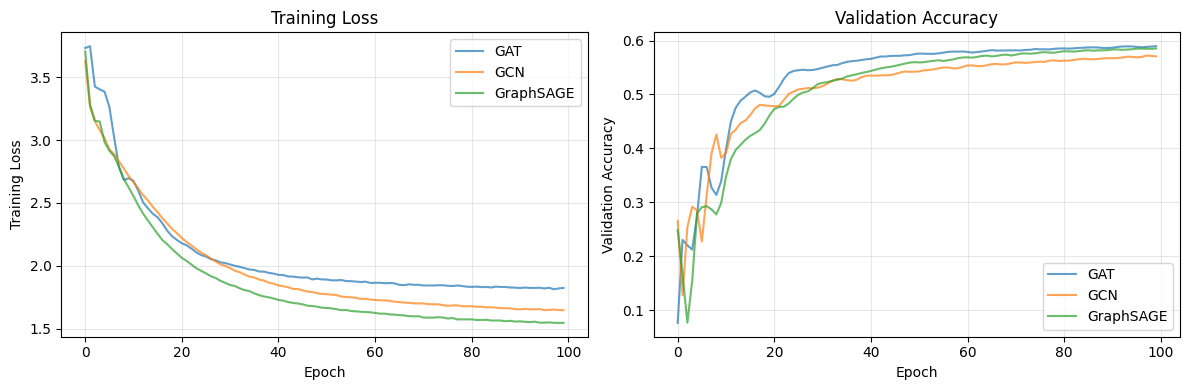

In [17]:
# Visualize
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(gat_history['train_loss'], label='GAT', alpha=0.7)
plt.plot(gcn_history['train_loss'], label='GCN', alpha=0.7)
plt.plot(sage_history['train_loss'], label='GraphSAGE', alpha=0.7)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(gat_history['val_acc'], label='GAT', alpha=0.7)
plt.plot(gcn_history['val_acc'], label='GCN', alpha=0.7)
plt.plot(sage_history['val_acc'], label='GraphSAGE', alpha=0.7)
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 🔗 Task 2: Link Prediction (Citation Prediction)

In [18]:
# Create edge splits
num_edges = data.edge_index.shape[1]
perm = torch.randperm(num_edges)

num_val = int(0.1 * num_edges)
num_test = int(0.1 * num_edges)

train_edges = data.edge_index[:, perm[num_val + num_test:]]
val_pos = data.edge_index[:, perm[:num_val]]
test_pos = data.edge_index[:, perm[num_val:num_val + num_test]]

# Sample negative edges
def sample_negative_edges(num_samples, existing_edges):
    edge_set = set(map(tuple, existing_edges.t().tolist()))
    neg_edges = []
    while len(neg_edges) < num_samples:
        src = torch.randint(0, data.num_nodes, (1,)).item()
        dst = torch.randint(0, data.num_nodes, (1,)).item()
        if src != dst and (src, dst) not in edge_set:
            neg_edges.append([src, dst])
    return torch.tensor(neg_edges, dtype=torch.long).t()

val_neg = sample_negative_edges(num_val, data.edge_index)
test_neg = sample_negative_edges(num_test, data.edge_index)

print(f"Edge splits created:")
print(f"Train: {train_edges.shape[1]:,} | Val: {val_pos.shape[1]:,} | Test: {test_pos.shape[1]:,}")

Edge splits created:
Train: 932,995 | Val: 116,624 | Test: 116,624


In [19]:
def train_link_prediction(model, data, train_edges, val_pos, val_neg, test_pos, test_neg, epochs=50, lr=0.01):
    model = model.to(device)
    data_train = Data(x=data.x.to(device), edge_index=train_edges.to(device))
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    history = {'train_loss': [], 'val_auc': []}
    best_val_auc = 0
    
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        
        z = model(data_train.x, data_train.edge_index)
        
        # Sample edges for training
        num_samples = min(5000, train_edges.shape[1])
        pos_idx = torch.randperm(train_edges.shape[1])[:num_samples]
        pos_edges = train_edges[:, pos_idx].to(device)
        neg_edges = sample_negative_edges(num_samples, train_edges).to(device)
        
        pos_score = (z[pos_edges[0]] * z[pos_edges[1]]).sum(dim=1)
        neg_score = (z[neg_edges[0]] * z[neg_edges[1]]).sum(dim=1)
        
        loss = -torch.log(torch.sigmoid(pos_score) + 1e-15).mean() - torch.log(1 - torch.sigmoid(neg_score) + 1e-15).mean()
        loss.backward()
        optimizer.step()
        
        history['train_loss'].append(loss.item())
        
        # Validation
        if (epoch + 1) % 10 == 0:
            model.eval()
            with torch.no_grad():
                z = model(data_train.x, data_train.edge_index)
                pos_score = (z[val_pos.to(device)[0]] * z[val_pos.to(device)[1]]).sum(dim=1)
                neg_score = (z[val_neg.to(device)[0]] * z[val_neg.to(device)[1]]).sum(dim=1)
                scores = torch.cat([pos_score, neg_score]).cpu().numpy()
                labels = np.concatenate([np.ones(len(pos_score)), np.zeros(len(neg_score))])
                val_auc = roc_auc_score(labels, scores)
                history['val_auc'].append(val_auc)
                if val_auc > best_val_auc:
                    best_val_auc = val_auc
                print(f"Epoch {epoch+1}: Loss={loss.item():.4f}, Val AUC={val_auc:.4f}")
    
    # Test
    model.eval()
    with torch.no_grad():
        z = model(data_train.x, data_train.edge_index)
        pos_score = (z[test_pos.to(device)[0]] * z[test_pos.to(device)[1]]).sum(dim=1)
        neg_score = (z[test_neg.to(device)[0]] * z[test_neg.to(device)[1]]).sum(dim=1)
        scores = torch.cat([pos_score, neg_score]).cpu().numpy()
        labels = np.concatenate([np.ones(len(pos_score)), np.zeros(len(neg_score))])
        test_auc = roc_auc_score(labels, scores)
    
    print(f"Final: Val AUC={best_val_auc:.4f}, Test AUC={test_auc:.4f}\n")
    return history, test_auc

In [20]:
# Train GAT for link prediction
print("Training GAT for Link Prediction...")
gat_link = GAT(data.num_features, 128, 64)
gat_link_hist, gat_test_auc = train_link_prediction(gat_link, data, train_edges, val_pos, val_neg, test_pos, test_neg, epochs=50)

Training GAT for Link Prediction...
Epoch 10: Loss=18.3963, Val AUC=0.6924
Epoch 10: Loss=18.3963, Val AUC=0.6924
Epoch 20: Loss=17.4001, Val AUC=0.7732
Epoch 20: Loss=17.4001, Val AUC=0.7732
Epoch 30: Loss=18.0929, Val AUC=0.7739
Epoch 30: Loss=18.0929, Val AUC=0.7739
Epoch 40: Loss=16.3537, Val AUC=0.7744
Epoch 40: Loss=16.3537, Val AUC=0.7744
Epoch 50: Loss=16.0790, Val AUC=0.7725
Epoch 50: Loss=16.0790, Val AUC=0.7725
Final: Val AUC=0.7744, Test AUC=0.7723

Final: Val AUC=0.7744, Test AUC=0.7723



In [21]:
# Train GCN for link prediction
print("Training GCN for Link Prediction...")
gcn_link = GCN(data.num_features, 128, 64)
gcn_link_hist, gcn_test_auc = train_link_prediction(gcn_link, data, train_edges, val_pos, val_neg, test_pos, test_neg, epochs=50)

Training GCN for Link Prediction...
Epoch 10: Loss=1.1727, Val AUC=0.8479
Epoch 10: Loss=1.1727, Val AUC=0.8479
Epoch 20: Loss=1.1414, Val AUC=0.8559
Epoch 20: Loss=1.1414, Val AUC=0.8559
Epoch 30: Loss=1.1006, Val AUC=0.8784
Epoch 30: Loss=1.1006, Val AUC=0.8784
Epoch 40: Loss=1.1121, Val AUC=0.8928
Epoch 40: Loss=1.1121, Val AUC=0.8928
Epoch 50: Loss=1.0781, Val AUC=0.9017
Final: Val AUC=0.9017, Test AUC=0.9012

Epoch 50: Loss=1.0781, Val AUC=0.9017
Final: Val AUC=0.9017, Test AUC=0.9012



In [22]:
# Train GraphSAGE for link prediction
print("Training GraphSAGE for Link Prediction...")
sage_link = GraphSAGE(data.num_features, 128, 64)
sage_link_hist, sage_test_auc = train_link_prediction(sage_link, data, train_edges, val_pos, val_neg, test_pos, test_neg, epochs=50)

Training GraphSAGE for Link Prediction...
Epoch 10: Loss=1.3923, Val AUC=0.6311
Epoch 10: Loss=1.3923, Val AUC=0.6311
Epoch 20: Loss=1.3596, Val AUC=0.7317
Epoch 20: Loss=1.3596, Val AUC=0.7317
Epoch 30: Loss=1.2786, Val AUC=0.7652
Epoch 30: Loss=1.2786, Val AUC=0.7652
Epoch 40: Loss=1.2550, Val AUC=0.8009
Epoch 40: Loss=1.2550, Val AUC=0.8009
Epoch 50: Loss=1.2373, Val AUC=0.7961
Epoch 50: Loss=1.2373, Val AUC=0.7961
Final: Val AUC=0.8009, Test AUC=0.7958

Final: Val AUC=0.8009, Test AUC=0.7958



In [23]:
# Results
results_link = pd.DataFrame({
    'Model': ['GAT', 'GCN', 'GraphSAGE'],
    'Test AUC': [gat_test_auc, gcn_test_auc, sage_test_auc]
})
print("\n" + "="*50)
print("LINK PREDICTION RESULTS")
print("="*50)
print(results_link.to_string(index=False))
print("="*50)


LINK PREDICTION RESULTS
    Model  Test AUC
      GAT  0.772271
      GCN  0.901159
GraphSAGE  0.795764


## 💾 Save Models

In [24]:
# Save the best models
Path('saved_models').mkdir(exist_ok=True)

torch.save({
    'gat_node': gat.state_dict(),
    'gcn_node': gcn.state_dict(),
    'sage_node': sage.state_dict(),
    'gat_link': gat_link.state_dict(),
    'gcn_link': gcn_link.state_dict(),
    'sage_link': sage_link.state_dict(),
    'results_node': results_node.to_dict(),
    'results_link': results_link.to_dict()
}, 'saved_models/all_models.pt')

print("✅ All models saved to saved_models/all_models.pt")

✅ All models saved to saved_models/all_models.pt


## 📊 Final Summary

In [25]:
print("\n" + "="*60)
print("UNIVERSITY GNN PROJECT - FINAL RESULTS")
print("="*60)
print("\n🎯 NODE CLASSIFICATION (Paper Topic Prediction)")
print("-" * 60)
print(results_node.to_string(index=False))
print("\n🔗 LINK PREDICTION (Citation Prediction)")
print("-" * 60)
print(results_link.to_string(index=False))
print("\n" + "="*60)
print("✅ Training Complete!")
print("📁 Models saved: saved_models/all_models.pt")
print("="*60)


UNIVERSITY GNN PROJECT - FINAL RESULTS

🎯 NODE CLASSIFICATION (Paper Topic Prediction)
------------------------------------------------------------
    Model  Test Accuracy
      GAT       0.533897
      GCN       0.503282
GraphSAGE       0.522684

🔗 LINK PREDICTION (Citation Prediction)
------------------------------------------------------------
    Model  Test AUC
      GAT  0.772271
      GCN  0.901159
GraphSAGE  0.795764

✅ Training Complete!
📁 Models saved: saved_models/all_models.pt
